# Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import copy

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# Google drive and paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# IMPORTANT: Update this path to where you uploaded your dataset folder
DATASET_PATH = '/content/drive/MyDrive/tinytrash_dataset'  # Change this!

Mounted at /content/drive


In [3]:
!ls ./drive/MyDrive/tinytrash_dataset/
!unzip ./drive/MyDrive/tinytrash_dataset/glass.zip
!unzip ./drive/MyDrive/tinytrash_dataset/metal.zip
!unzip ./drive/MyDrive/tinytrash_dataset/paper.zip
!unzip ./drive/MyDrive/tinytrash_dataset/plastic.zip

glass.zip  metal.zip  paper.zip  plastic.zip
Archive:  ./drive/MyDrive/tinytrash_dataset/glass.zip
 extracting: glass/IMG_7538.jpg      
 extracting: glass/IMG_7539.jpg      
 extracting: glass/IMG_7540.jpg      
 extracting: glass/IMG_7541.jpg      
 extracting: glass/IMG_7543.jpg      
 extracting: glass/IMG_7544.jpg      
 extracting: glass/IMG_7546.jpg      
 extracting: glass/IMG_7547.jpg      
 extracting: glass/IMG_7548.jpg      
 extracting: glass/IMG_7549.jpg      
 extracting: glass/IMG_7550.jpg      
 extracting: glass/IMG_7552.jpg      
 extracting: glass/IMG_7553.jpg      
 extracting: glass/IMG_7554.jpg      
 extracting: glass/IMG_7555.jpg      
 extracting: glass/IMG_7558.jpg      
 extracting: glass/IMG_7559.jpg      
 extracting: glass/IMG_7560.jpg      
 extracting: glass/IMG_7561.jpg      
 extracting: glass/IMG_7562.jpg      
 extracting: glass/IMG_7563.jpg      
 extracting: glass/IMG_7564.jpg      
 extracting: glass/IMG_7565.jpg      
 extracting: glass/IMG_7566

In [4]:
!mkdir tinytrash_dataset

!cp -r ./glass ./tinytrash_dataset/
!cp -r ./metal ./tinytrash_dataset/
!cp -r ./paper ./tinytrash_dataset/
!cp -r ./plastic ./tinytrash_dataset/

In [5]:
# IMPORTANT: Update this path to where you uploaded your dataset folder
DATASET_PATH = '/content/tinytrash_dataset/'  # Change this!

# Verify dataset structure
print("\nDataset structure:")
for category in sorted(os.listdir(DATASET_PATH)):
    category_path = os.path.join(DATASET_PATH, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path)
                         if f.endswith(('.jpg', '.jpeg'))])
        print(f"  {category}: {num_images} images")


Dataset structure:
  glass: 202 images
  metal: 205 images
  paper: 204 images
  plastic: 205 images


# Data Agumentation and Preprocessing

In [6]:
IMG_SIZE = 224  # Standard input size for MobileNetV2

# Training augmentation (aggressive for better generalization)
train_transforms = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("\nTransforms configured!")


Transforms configured!


# Dataset and Dataloaders

In [7]:
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transforms)

# Print class mapping
print("\nClass mapping (alphabetical order):")
for idx, class_name in enumerate(full_dataset.classes):
    print(f"  {idx}: {class_name}")

# Split into train (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create a copy of validation dataset with different transforms
val_dataset_copy = copy.deepcopy(full_dataset)
val_dataset_copy.transform = val_transforms
val_indices = val_dataset.indices
val_dataset = torch.utils.data.Subset(val_dataset_copy, val_indices)

print(f"\nDataset split:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# Create data loaders
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Class mapping (alphabetical order):
  0: glass
  1: metal
  2: paper
  3: plastic

Dataset split:
  Training samples: 652
  Validation samples: 164

Batch size: 64
Training batches: 11
Validation batches: 3


# Sample Augmented Images

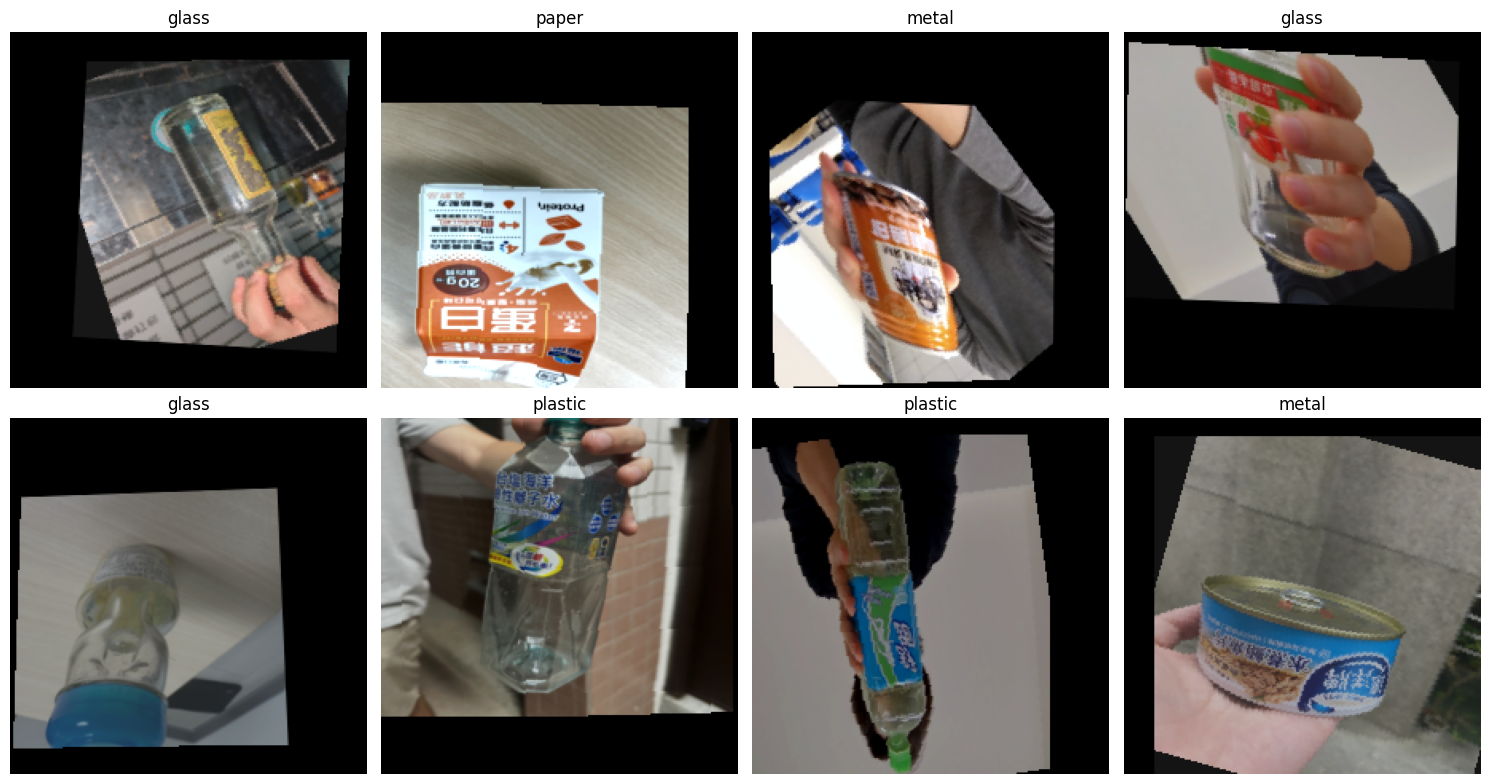

In [20]:
def imshow(img, title):
    """Helper function to display images"""
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch
images, labels = next(iter(train_loader))

# Show first 8 images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        plt.sca(ax)
        imshow(images[idx], full_dataset.classes[labels[idx]])
plt.tight_layout()
plt.savefig('augmented_images.png')
plt.show()

# Model

In [9]:
TRAIN_PERCENTAGE = 0.1  # ← Change this value (0.0 to 1.0)
model = models.mobilenet_v2(pretrained=True)

# Modify the final classifier for 4 classes
num_classes = 4  # glass, metal, paper, plastic
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move model to GPU
model = model.to(device)

print("\nModel architecture:")
print(model.classifier)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 74.9MB/s]



Model architecture:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

Total parameters: 2,228,996
Trainable parameters: 2,228,996


# Freeze / Unfreeze Layers

In [10]:
if TRAIN_PERCENTAGE < 1.0:
    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Always train the final classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Unfreeze additional layers based on percentage
    if TRAIN_PERCENTAGE > 0.0:
        # Get all feature layers (backbone)
        feature_layers = list(model.features.children())
        num_layers = len(feature_layers)

        # Calculate how many layers to train
        layers_to_train = int(num_layers * TRAIN_PERCENTAGE)

        # Unfreeze the last N layers
        for layer in feature_layers[-layers_to_train:]:
            for param in layer.parameters():
                param.requires_grad = True

        print(f"\n✓ Training last {layers_to_train}/{num_layers} feature layers + classifier")
    else:
        print(f"\n✓ Training only the final classifier (feature extractor frozen)")
else:
    print(f"\n✓ Training entire model (all layers)")

# Move model to GPU
model = model.to(device)

print("\nModel architecture:")
print(model.classifier)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")


✓ Training last 1/19 feature layers + classifier

Model architecture:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

Total parameters: 2,228,996
Trainable parameters: 417,284
Frozen parameters: 1,811,712


# Training Setup

In [11]:
# Adjust learning rate based on fine-tuning strategy
# Higher LR for classifier-only training, lower for full model training
if TRAIN_PERCENTAGE == 0.0:
    LEARNING_RATE = 0.001  # Higher LR for frozen backbone
elif TRAIN_PERCENTAGE < 0.5:
    LEARNING_RATE = 0.0005  # Medium LR for partial fine-tuning
else:
    LEARNING_RATE = 0.0001  # Lower LR for training most of the model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

print("\nTraining setup complete!")
print(f"Optimizer: Adam")
print(f"Initial learning rate: {LEARNING_RATE}")
print(f"Loss function: CrossEntropyLoss")
print(f"Training strategy: {TRAIN_PERCENTAGE*100:.0f}% of feature layers + classifier")


Training setup complete!
Optimizer: Adam
Initial learning rate: 0.0005
Loss function: CrossEntropyLoss
Training strategy: 10% of feature layers + classifier


# Training Functions

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

# Training Loop

In [13]:
NUM_EPOCHS = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\n{'='*60}")
print(f"Starting training for {NUM_EPOCHS} epochs")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print('-' * 60)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"  ✓ New best validation accuracy: {best_val_acc:.2f}%")

print(f"\n{'='*60}")
print(f"Training complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}\n")

# Load best model weights
model.load_state_dict(best_model_wts)


Starting training for 30 epochs


Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it, loss=0.7288, acc=78.66%]



Epoch 1 Summary:
  Train Loss: 1.0959 | Train Acc: 56.29%
  Val Loss:   0.7677 | Val Acc:   78.66%
  LR: 0.000500
  ✓ New best validation accuracy: 78.66%

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.25s/it, loss=0.5825, acc=84.15%]



Epoch 2 Summary:
  Train Loss: 0.6653 | Train Acc: 80.06%
  Val Loss:   0.6029 | Val Acc:   84.15%
  LR: 0.000500
  ✓ New best validation accuracy: 84.15%

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it, loss=0.5144, acc=84.76%]



Epoch 3 Summary:
  Train Loss: 0.4866 | Train Acc: 85.43%
  Val Loss:   0.5086 | Val Acc:   84.76%
  LR: 0.000500
  ✓ New best validation accuracy: 84.76%

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.44s/it, loss=0.4335, acc=82.32%]



Epoch 4 Summary:
  Train Loss: 0.4324 | Train Acc: 86.66%
  Val Loss:   0.4594 | Val Acc:   82.32%
  LR: 0.000500

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it, loss=0.4206, acc=86.59%]



Epoch 5 Summary:
  Train Loss: 0.3934 | Train Acc: 86.20%
  Val Loss:   0.4181 | Val Acc:   86.59%
  LR: 0.000500
  ✓ New best validation accuracy: 86.59%

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, loss=0.4043, acc=85.98%]



Epoch 6 Summary:
  Train Loss: 0.3478 | Train Acc: 88.50%
  Val Loss:   0.4099 | Val Acc:   85.98%
  LR: 0.000500

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.48s/it, loss=0.3687, acc=84.76%]



Epoch 7 Summary:
  Train Loss: 0.3350 | Train Acc: 87.42%
  Val Loss:   0.4124 | Val Acc:   84.76%
  LR: 0.000500

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.51s/it, loss=0.3310, acc=85.37%]



Epoch 8 Summary:
  Train Loss: 0.2894 | Train Acc: 90.64%
  Val Loss:   0.3609 | Val Acc:   85.37%
  LR: 0.000500

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.50s/it, loss=0.3536, acc=87.20%]



Epoch 9 Summary:
  Train Loss: 0.2879 | Train Acc: 89.88%
  Val Loss:   0.3503 | Val Acc:   87.20%
  LR: 0.000500
  ✓ New best validation accuracy: 87.20%

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it, loss=0.2767, acc=86.59%]



Epoch 10 Summary:
  Train Loss: 0.3079 | Train Acc: 88.96%
  Val Loss:   0.3324 | Val Acc:   86.59%
  LR: 0.000500

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it, loss=0.3018, acc=85.98%]



Epoch 11 Summary:
  Train Loss: 0.2745 | Train Acc: 90.80%
  Val Loss:   0.3461 | Val Acc:   85.98%
  LR: 0.000500

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.51s/it, loss=0.3028, acc=90.24%]



Epoch 12 Summary:
  Train Loss: 0.2516 | Train Acc: 91.26%
  Val Loss:   0.2930 | Val Acc:   90.24%
  LR: 0.000500
  ✓ New best validation accuracy: 90.24%

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it, loss=0.2794, acc=88.41%]



Epoch 13 Summary:
  Train Loss: 0.2428 | Train Acc: 92.02%
  Val Loss:   0.2896 | Val Acc:   88.41%
  LR: 0.000500

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it, loss=0.2767, acc=86.59%]



Epoch 14 Summary:
  Train Loss: 0.2188 | Train Acc: 93.10%
  Val Loss:   0.3174 | Val Acc:   86.59%
  LR: 0.000500

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it, loss=0.2657, acc=91.46%]



Epoch 15 Summary:
  Train Loss: 0.2101 | Train Acc: 92.48%
  Val Loss:   0.2709 | Val Acc:   91.46%
  LR: 0.000500
  ✓ New best validation accuracy: 91.46%

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it, loss=0.2831, acc=90.85%]



Epoch 16 Summary:
  Train Loss: 0.2358 | Train Acc: 92.18%
  Val Loss:   0.2577 | Val Acc:   90.85%
  LR: 0.000500

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it, loss=0.2938, acc=91.46%]



Epoch 17 Summary:
  Train Loss: 0.2278 | Train Acc: 93.25%
  Val Loss:   0.2491 | Val Acc:   91.46%
  LR: 0.000500

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.40s/it, loss=0.2985, acc=90.85%]



Epoch 18 Summary:
  Train Loss: 0.2055 | Train Acc: 93.25%
  Val Loss:   0.2432 | Val Acc:   90.85%
  LR: 0.000500

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.61s/it, loss=0.2463, acc=92.07%]



Epoch 19 Summary:
  Train Loss: 0.1662 | Train Acc: 94.94%
  Val Loss:   0.2507 | Val Acc:   92.07%
  LR: 0.000500
  ✓ New best validation accuracy: 92.07%

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.62s/it, loss=0.2421, acc=90.24%]



Epoch 20 Summary:
  Train Loss: 0.1917 | Train Acc: 93.25%
  Val Loss:   0.2588 | Val Acc:   90.24%
  LR: 0.000500

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it, loss=0.2478, acc=89.02%]



Epoch 21 Summary:
  Train Loss: 0.2041 | Train Acc: 92.48%
  Val Loss:   0.2487 | Val Acc:   89.02%
  LR: 0.000500

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.57s/it, loss=0.2614, acc=89.63%]



Epoch 22 Summary:
  Train Loss: 0.1646 | Train Acc: 95.09%
  Val Loss:   0.2594 | Val Acc:   89.63%
  LR: 0.000250

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it, loss=0.2556, acc=89.63%]



Epoch 23 Summary:
  Train Loss: 0.1876 | Train Acc: 93.40%
  Val Loss:   0.2720 | Val Acc:   89.63%
  LR: 0.000250

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it, loss=0.2523, acc=89.63%]



Epoch 24 Summary:
  Train Loss: 0.1821 | Train Acc: 93.40%
  Val Loss:   0.2562 | Val Acc:   89.63%
  LR: 0.000250

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it, loss=0.2178, acc=90.85%]



Epoch 25 Summary:
  Train Loss: 0.1708 | Train Acc: 93.71%
  Val Loss:   0.2511 | Val Acc:   90.85%
  LR: 0.000250

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it, loss=0.2145, acc=90.24%]



Epoch 26 Summary:
  Train Loss: 0.1561 | Train Acc: 94.17%
  Val Loss:   0.2524 | Val Acc:   90.24%
  LR: 0.000125

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.20s/it, loss=0.2106, acc=89.63%]



Epoch 27 Summary:
  Train Loss: 0.1559 | Train Acc: 94.79%
  Val Loss:   0.2613 | Val Acc:   89.63%
  LR: 0.000125

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it, loss=0.2260, acc=90.24%]



Epoch 28 Summary:
  Train Loss: 0.1384 | Train Acc: 95.55%
  Val Loss:   0.2535 | Val Acc:   90.24%
  LR: 0.000125

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it, loss=0.2078, acc=92.07%]



Epoch 29 Summary:
  Train Loss: 0.1720 | Train Acc: 93.71%
  Val Loss:   0.2299 | Val Acc:   92.07%
  LR: 0.000125

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it, loss=0.2211, acc=89.63%]


Epoch 30 Summary:
  Train Loss: 0.1542 | Train Acc: 95.25%
  Val Loss:   0.2492 | Val Acc:   89.63%
  LR: 0.000125

Training complete!
Best validation accuracy: 92.07%



<All keys matched successfully>

# Plots

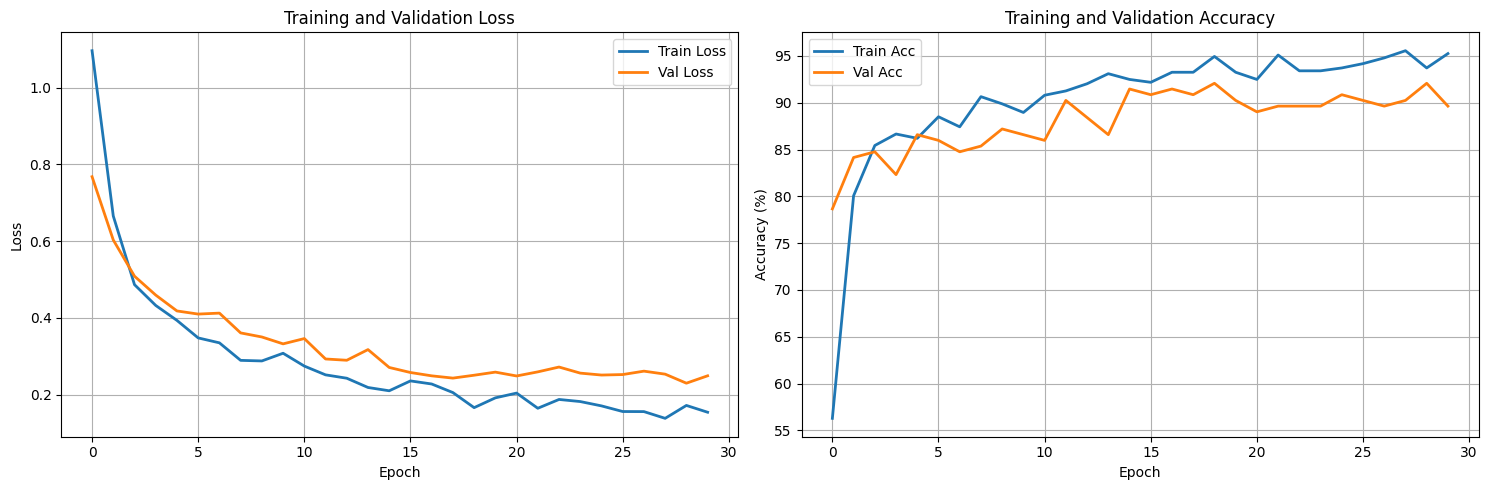

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('graphs_training.png')
plt.show()

# Save Model

In [15]:
# Save to Google Drive
# SAVE_PATH = '/content/tinytrash_model.pth'

# Create directory if it doesn't exist
# os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# Save model weights
# torch.save(model.state_dict(), SAVE_PATH)
# print(f"\n✓ Model saved to: {SAVE_PATH}")

# Also save to local for immediate download
LOCAL_SAVE = 'tinytrash_model.pth'
torch.save(model.state_dict(), LOCAL_SAVE)
print(f"✓ Model saved locally: {LOCAL_SAVE}")

# Download the model file
from google.colab import files
files.download(LOCAL_SAVE)
print("\n✓ Model downloaded! Check your Downloads folder.")

✓ Model saved locally: tinytrash_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Model downloaded! Check your Downloads folder.


# Confusion Matrix

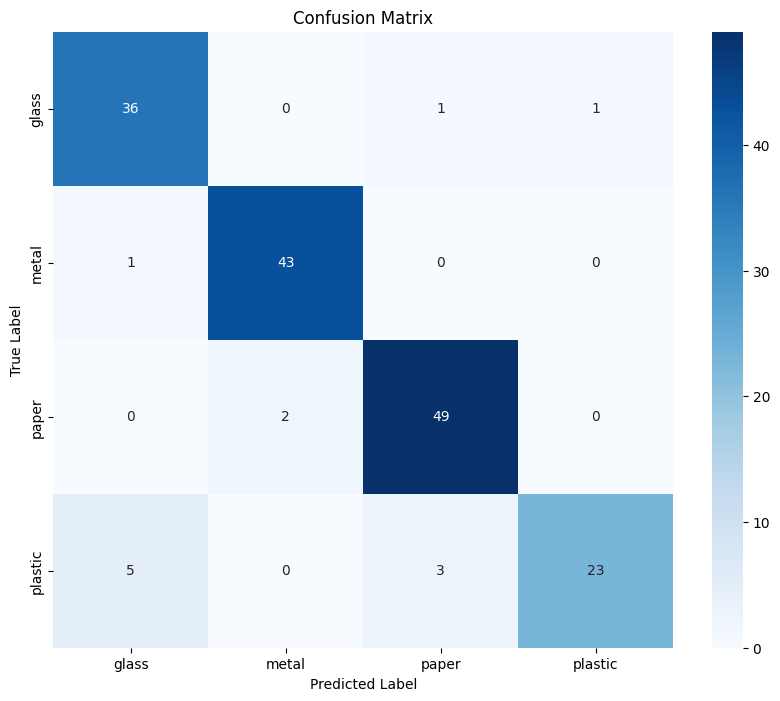


Classification Report:
              precision    recall  f1-score   support

       glass      0.857     0.947     0.900        38
       metal      0.956     0.977     0.966        44
       paper      0.925     0.961     0.942        51
     plastic      0.958     0.742     0.836        31

    accuracy                          0.921       164
   macro avg      0.924     0.907     0.911       164
weighted avg      0.924     0.921     0.919       164



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                           target_names=full_dataset.classes,
                           digits=3))

# Summary

In [21]:
"""
Add this as the LAST CELL in your tinytrash.ipynb notebook
This cell collects and saves all training metrics to JSON and CSV files
"""

import json
import pandas as pd
from datetime import datetime
from sklearn.metrics import classification_report, f1_score
import torch

# ============================================================================
# COLLECT ALL METRICS
# ============================================================================

print("\n" + "="*60)
print("COLLECTING TRAINING METRICS")
print("="*60)

# Get timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Calculate F1 scores on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get classification report
class_report = classification_report(all_labels, all_preds,
                                     target_names=full_dataset.classes,
                                     output_dict=True)

# Calculate per-class F1 scores
f1_scores_per_class = {
    cls: class_report[cls]['f1-score']
    for cls in full_dataset.classes
}

# Calculate macro and weighted F1
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

# ============================================================================
# BUILD METRICS DICTIONARY
# ============================================================================

metrics = {
    # Metadata
    "timestamp": timestamp,
    "experiment_name": "TinyTrash Training Run",

    # Training Configuration
    "training_config": {
        "num_epochs": NUM_EPOCHS,
        "batch_size": train_loader.batch_size,
        "optimizer": optimizer.__class__.__name__,
        "initial_learning_rate": LEARNING_RATE,
        "final_learning_rate": optimizer.param_groups[0]['lr'],
        "loss_function": criterion.__class__.__name__,
        "train_percentage": TRAIN_PERCENTAGE,
        "training_strategy": f"{TRAIN_PERCENTAGE*100:.0f}% of feature layers + classifier"
    },

    # Model Architecture
    "model": {
        "architecture": "MobileNetV2",
        "num_classes": len(CATEGORIES),
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "frozen_parameters": sum(p.numel() for p in model.parameters() if not p.requires_grad),
        "layers_trained": f"Last {int(len(list(model.features.children())) * TRAIN_PERCENTAGE)}/{len(list(model.features.children()))} feature layers + classifier"
    },

    # Dataset Information
    "dataset": {
        "categories": CATEGORIES,
        "class_mapping": {i: cls for i, cls in enumerate(full_dataset.classes)},
        "total_images": len(full_dataset),
        "training_samples": len(train_dataset),
        "validation_samples": len(val_dataset),
        "split_ratio": f"{len(train_dataset)/len(full_dataset)*100:.0f}% train / {len(val_dataset)/len(full_dataset)*100:.0f}% val",
        "training_batches": len(train_loader),
        "validation_batches": len(val_loader),
        "images_per_category": {
            cls: len([1 for path, label in full_dataset.samples if full_dataset.classes[label] == cls])
            for cls in full_dataset.classes
        }
    },

    # Training History
    "training_history": {
        "train_losses": [float(loss) for loss in train_losses],
        "train_accuracies": [float(acc) for acc in train_accs],
        "val_losses": [float(loss) for loss in val_losses],
        "val_accuracies": [float(acc) for acc in val_accs]
    },

    # Final Metrics
    "final_metrics": {
        "best_val_accuracy": float(best_val_acc),
        "final_train_loss": float(train_losses[-1]),
        "final_train_accuracy": float(train_accs[-1]),
        "final_val_loss": float(val_losses[-1]),
        "final_val_accuracy": float(val_accs[-1]),
        "epochs_trained": len(train_losses)
    },

    # F1 Scores
    "f1_scores": {
        "per_class": f1_scores_per_class,
        "macro_avg": float(f1_macro),
        "weighted_avg": float(f1_weighted)
    },

    # Detailed Classification Report
    "classification_report": {
        cls: {
            "precision": float(class_report[cls]['precision']),
            "recall": float(class_report[cls]['recall']),
            "f1-score": float(class_report[cls]['f1-score']),
            "support": int(class_report[cls]['support'])
        }
        for cls in full_dataset.classes
    },

    # Overall Classification Metrics
    "overall_metrics": {
        "accuracy": float(class_report['accuracy']),
        "macro_avg_precision": float(class_report['macro avg']['precision']),
        "macro_avg_recall": float(class_report['macro avg']['recall']),
        "macro_avg_f1": float(class_report['macro avg']['f1-score']),
        "weighted_avg_precision": float(class_report['weighted avg']['precision']),
        "weighted_avg_recall": float(class_report['weighted avg']['recall']),
        "weighted_avg_f1": float(class_report['weighted avg']['f1-score'])
    }
}

# ============================================================================
# SAVE TO JSON (Best for structured data)
# ============================================================================

json_filename = f"training_metrics_{timestamp}.json"
with open(json_filename, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n✓ Saved comprehensive metrics to: {json_filename}")

# ============================================================================
# SAVE TO CSV (Easy to view in Excel/Google Sheets)
# ============================================================================

# Flatten metrics for CSV
csv_data = {
    "Timestamp": timestamp,
    "Epochs": NUM_EPOCHS,
    "Batch Size": train_loader.batch_size,
    "Optimizer": optimizer.__class__.__name__,
    "Initial LR": LEARNING_RATE,
    "Final LR": optimizer.param_groups[0]['lr'],
    "Train Strategy": f"{TRAIN_PERCENTAGE*100:.0f}% layers",
    "Total Params": sum(p.numel() for p in model.parameters()),
    "Trainable Params": sum(p.numel() for p in model.parameters() if p.requires_grad),
    "Total Images": len(full_dataset),
    "Train Samples": len(train_dataset),
    "Val Samples": len(val_dataset),
    "Best Val Acc": f"{best_val_acc:.2f}%",
    "Final Train Loss": f"{train_losses[-1]:.4f}",
    "Final Train Acc": f"{train_accs[-1]:.2f}%",
    "Final Val Loss": f"{val_losses[-1]:.4f}",
    "Final Val Acc": f"{val_accs[-1]:.2f}%",
    "F1 Macro": f"{f1_macro:.4f}",
    "F1 Weighted": f"{f1_weighted:.4f}",
}

# Add per-class F1 scores
for cls in full_dataset.classes:
    csv_data[f"F1_{cls.capitalize()}"] = f"{f1_scores_per_class[cls]:.4f}"

# Save to CSV
csv_filename = f"training_summary_{timestamp}.csv"
df = pd.DataFrame([csv_data])
df.to_csv(csv_filename, index=False)

print(f"✓ Saved summary to CSV: {csv_filename}")

# ============================================================================
# PRINT SUMMARY TO CONSOLE
# ============================================================================

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nModel: MobileNetV2")
print(f"Strategy: {TRAIN_PERCENTAGE*100:.0f}% of feature layers + classifier")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\nDataset:")
print(f"  Training: {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Batch size: {train_loader.batch_size}")
print(f"\nTraining Results:")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"  Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"  Final Val Loss: {val_losses[-1]:.4f}")
print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")
print(f"\nF1 Scores:")
print(f"  Macro Average: {f1_macro:.4f}")
print(f"  Weighted Average: {f1_weighted:.4f}")
print(f"\nPer-Class F1 Scores:")
for cls in full_dataset.classes:
    print(f"  {cls.capitalize()}: {f1_scores_per_class[cls]:.4f}")
print("\n" + "="*60)
print(f"Metrics saved to:")
print(f"  📄 {json_filename}")
print(f"  📊 {csv_filename}")
print("="*60)

# ============================================================================
# OPTIONAL: Create comparison CSV for multiple runs
# ============================================================================

# Append to master CSV (for comparing multiple training runs)
master_csv = "training_runs_comparison.csv"
import os

if os.path.exists(master_csv):
    # Append to existing
    df_existing = pd.read_csv(master_csv)
    df_combined = pd.concat([df_existing, df], ignore_index=True)
    df_combined.to_csv(master_csv, index=False)
    print(f"✓ Added to comparison file: {master_csv}")
else:
    # Create new
    df.to_csv(master_csv, index=False)
    print(f"✓ Created comparison file: {master_csv}")

print("\n🎉 Metrics collection complete!")


COLLECTING TRAINING METRICS


NameError: name 'CATEGORIES' is not defined